In [52]:
from pygdsm import GlobalSkyModel16 as gsm16
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import healpy as hp
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
import astropy.units as u
from croissant import Rotator

In [2]:
# XXX can be more specific, this is hermit's cabin
LON = -113.40314938247553
LAT = 39.247824561729296
loc = EarthLocation(LON, LAT)

FREQ = 75

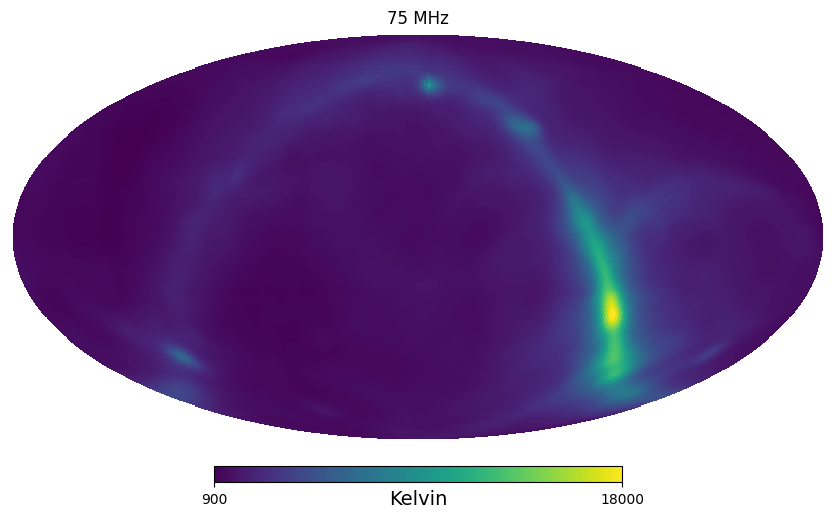

In [8]:
gsm = gsm16(freq_unit="MHz", data_unit="TRJ", resolution="low", include_cmb=True)
m = gsm.generate(FREQ)
m = Rotator(coord="GC").rotate_map_alms(m)  # rotate to equatorial firsr
hp.mollview(m, cbar=True, title=f"{FREQ} MHz", min=900, max=18e3, unit="Kelvin")

In [71]:
year = 2024
t0 = Time(f"{year}-01-01T00:00:00")
ntimes = 120  # times per day
if year % 4 == 0 and not year % 100 == 0 or year % 400 == 0:  # important to be careful about this stuff
    ndays = 366
else:
    ndays = 365
# from 6pm to 6am every night
times = (t0- 1/4 * u.day) + np.arange(ndays)[:, None] * u.day + np.arange(ntimes)[None, :] * 1/2 * u.day / ntimes
avg_t = np.empty(times.size)
horizon = np.where(hp.pix2ang(hp.get_nside(m), np.arange(hp.get_map_size(m)))[0] <= np.pi/2, 1, 0)
for i, time in enumerate(times.ravel()):
    rot = Rotator(coord="CT", loc=loc, time=time)
    rm = rot.rotate_map_alms(m)
    avg_t[i] = np.sum(rm[horizon])
avg_t = avg_t.reshape(times.shape)

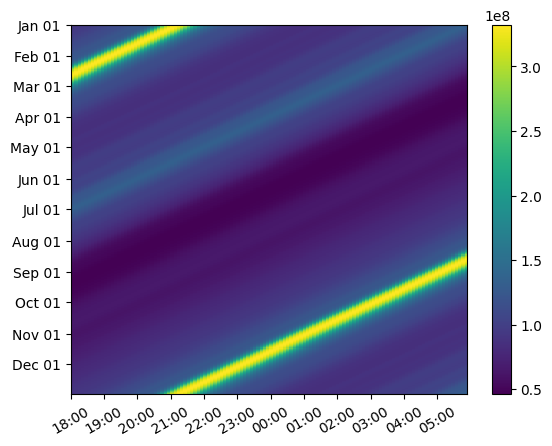

In [72]:
extent = [times[0, 0], times[0, -1], times[-1, 0], times[0, 0]]
extent = [t.datetime for t in extent]
plt.figure()
plt.imshow(avg_t, aspect="auto", interpolation="none", extent=extent)
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=30)
plt.colorbar()
plt.show()

Jul 16


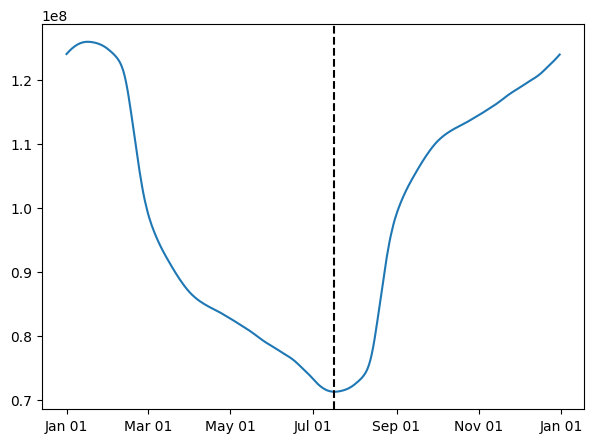

In [103]:
plt.figure(figsize=(7, 5))
plt.plot(times[:, 0].datetime, avg_t.mean(axis=-1))
best_day = times[np.argmin(avg_t.mean(axis=1)), 0]
print(best_day.datetime.strftime("%b %d"))
plt.axvline(best_day.datetime, ls="--", c="k")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()